In [1]:
import os, time, copy
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as vmodels
import torchvision.datasets as vdatasets

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image as pil_image

import numpy as np
from skimage.transform import resize

torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
BATCH_SIZE = 4

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(197),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((197, 197)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = "../datasets/presidential_candidates_2017/"
image_datasets = {x: vdatasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'validation']}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
               'validation': torch.utils.data.DataLoader(image_datasets['validation'], BATCH_SIZE, shuffle=False)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
nb_classes = len(image_datasets['train'].classes)

In [5]:
class Resnet_fc(nn.Module):
    def __init__(self, base_model, nb_classes):
        super(Resnet_fc, self).__init__()

        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])

        tmp = OrderedDict()
        tmp['last_conv'] = nn.Conv2d(2048, nb_classes, 1, 1)
        tmp['gap'] = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)

        self.classifier_layer = nn.Sequential(tmp)

    def forward(self, inputs):
        features = self.feature_extractor(inputs)
        x = self.classifier_layer(features)
        return x, features

In [6]:
base_model = vmodels.resnet50(pretrained=False)
net = Resnet_fc(base_model, 5)
net.load_state_dict(torch.load("../weights/pred_fullyconv/acolbase_e13.pth.tar", map_location='cpu'))
net.eval()
net.to(device)


Resnet_fc(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64

In [7]:
image_datasets['train'].class_to_idx

{'ahn': 0, 'hong': 1, 'moon': 2, 'sim': 3, 'you': 4}

In [89]:
img_path = "samples/moon3.JPG"
cls = 2


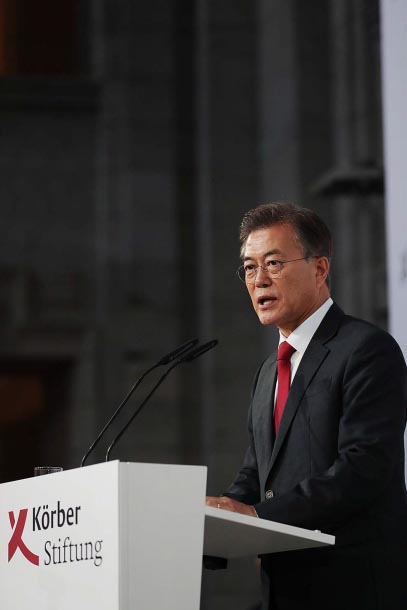

In [90]:
pil_image.open(img_path)

In [112]:
img = pil_image.open(img_path)
img_array = np.asarray(img)

In [113]:
# inp_tensor = data_transforms['validation'](img).unsqueeze(0)

In [114]:
def pad_image(vimg_array):
    h, w = vimg_array.shape[:2]
    
    if h == w:
        print("no padding needed")
        return vimg_array / 255., (h, w)
    elif h > w:
        print("padding left and right")
        pad_length = int((h - w) / 2)
        pad_left = np.zeros((h, pad_length,  3))
        pad_right = np.zeros((h, pad_length,  3))
        padded = np.hstack((pad_left, vimg_array, pad_right))
        padded_resized = resize(padded, (h, h)) / 255.
        return padded_resized, (h, h)
    elif w > h:
        print("padding up and bottom")
        pad_length = int((w - h) / 2)
        pad_up = np.zeros((pad_length, w, 3))
        pad_bottom = np.zeros((pad_length, w, 3))
        padded = np.vstack((pad_up, vimg_array, pad_bottom))
        padded_resized = resize(padded, (w, w)) / 255.
        return padded_resized, (w, w)
        
        
padded_image, (h, w) = pad_image(img_array)

padding left and right


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


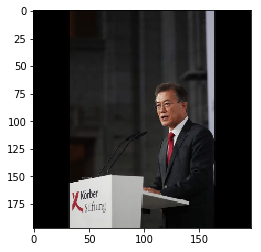

In [118]:
padded_resized = resize(padded_image, (197, 197))
plt.imshow(padded_resized)

In [117]:
test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [119]:
to_feed = copy.deepcopy(padded_resized)
inp_tensor = test_transforms(to_feed).unsqueeze(0).float()
inp_tensor = inp_tensor.to(device)

In [120]:
output, features = net(inp_tensor)

In [121]:
max_label = torch.max(F.softmax(output[0], dim=0), dim=0)[1].int()

In [122]:
max_label

tensor([[ 2]], dtype=torch.int32)

In [123]:
thres = (torch.max(F.softmax(output[0], dim=0), dim=0)[0] < 0.6)

In [124]:
max_label.masked_fill(thres, -1)

tensor([[-1]], dtype=torch.int32)

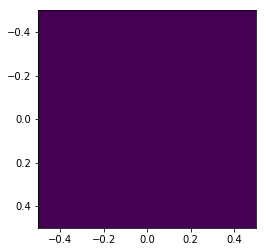

In [125]:
plt.imshow(torch.max(F.softmax(output[0], dim=0), dim=0)[1].detach().numpy())

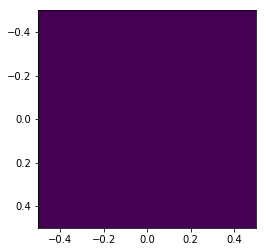

In [126]:
plt.imshow(F.softmax(output[0], dim=0)[cls, :, :].detach().numpy())

In [127]:
s = features.size()[3]

In [128]:
sl = s-7+1

In [129]:
W_conv = net.classifier_layer.last_conv.weight.detach()
W_conv_c = W_conv[cls]

In [130]:
A_conv_c = torch.zeros(1, s, s)
for i in range(sl):
    for j in range(sl):
        a_conv_c = (features[:, :, i:i+7, j:j+7] * W_conv_c).sum(1)
        A_conv_c[:, i:i+7, j:j+7] = torch.max(A_conv_c[:, i:i+7, j:j+7], a_conv_c)
_min = A_conv_c.min(-1, keepdim=True)[0].min(-2, keepdim=True)[0]
_max = A_conv_c.max(-1, keepdim=True)[0].max(-2, keepdim=True)[0]
A_conv_c_normalized = (A_conv_c - _min) / (_max - _min)

/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/jastills/anaconda3/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


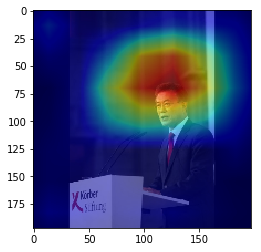

In [132]:
# plt.imshow(padded_image)
plt.imshow(resize(padded_resized, (197, 197)))
plt.imshow(resize(A_conv_c_normalized[0].detach().numpy(), (197, 197)), cmap='jet', alpha=0.5)

In [109]:
cls

2

In [110]:
A_conv_c.size()

torch.Size([1, 7, 7])

In [111]:
F.softmax(output, dim=1)

tensor([[[[ 0.0688]],

         [[ 0.4667]],

         [[ 0.1938]],

         [[ 0.0024]],

         [[ 0.2684]]]])

In [64]:
s

20